c:\Users\santhosh\OneDrive\Desktop\AI_Sales_Analytics_Dashboard\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2649
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2554
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2459
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2366
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2275
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2182
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2089
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1994
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1900
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1806
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1713
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1620
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1528
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1438
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1349
Epoch 16/100
1/1 ━

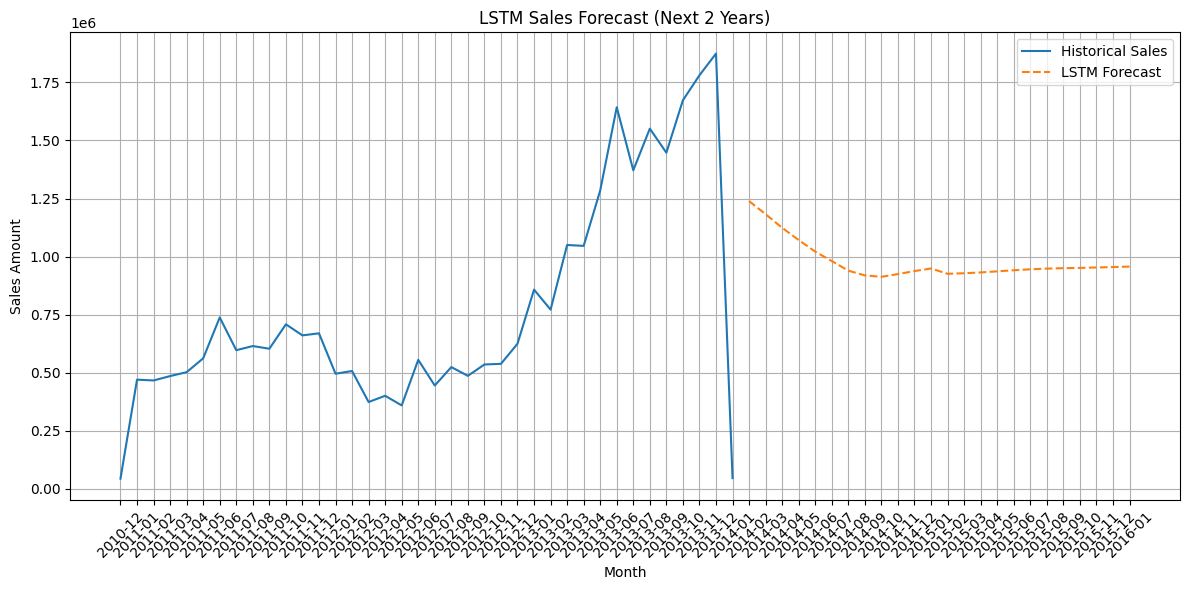

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Load and Prepare Monthly Sales
df = pd.read_csv("../data/cleaned_sales_data.csv")
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
monthly_sales = df.groupby(df['OrderDate'].dt.to_period('M')).agg({'SalesAmount': 'sum'}).reset_index()
monthly_sales['OrderDate'] = monthly_sales['OrderDate'].astype(str)
monthly_sales.rename(columns={'OrderDate': 'Month', 'SalesAmount': 'Sales'}, inplace=True)

# Step 2: Normalize Sales Values
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(monthly_sales['Sales'].values.reshape(-1, 1))

# Step 3: Create Time-Series Dataset for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 12  # 12 months lookback
X, y = create_sequences(sales_scaled, n_steps)

# Step 4: Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 5: Build LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=1)

# Step 6: Forecast Next 24 Months
forecast_input = sales_scaled[-n_steps:].reshape(1, n_steps, 1)
forecasted = []

for _ in range(24):  # 24 months
    next_val = model.predict(forecast_input)[0][0]
    forecasted.append(next_val)
    forecast_input = np.append(forecast_input[:, 1:, :], [[[next_val]]], axis=1)

# Step 7: Inverse Transform Predictions
forecasted_actual = scaler.inverse_transform(np.array(forecasted).reshape(-1, 1)).flatten()

# Step 8: Create Date Range for Predictions
last_month = pd.to_datetime(monthly_sales['Month'].iloc[-1])
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=24, freq='MS')

# Step 9: Save Forecast
forecast_df = pd.DataFrame({
    'Month': future_months.strftime('%Y-%m'),
    'PredictedSales': forecasted_actual
})
forecast_df.to_csv("../visualization/lstm_sales_forecast.csv", index=False)
print("Forecast saved to: visualizations/lstm_sales_forecast.csv")

# Step 10: Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Month'], monthly_sales['Sales'], label='Historical Sales')
plt.plot(forecast_df['Month'], forecast_df['PredictedSales'], label='LSTM Forecast', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Sales Amount")
plt.title("LSTM Sales Forecast (Next 2 Years)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# STEP ⬅ Compare with Actuals
# We'll compare the last 24 actual values (before forecast)
actual_last_24 = monthly_sales['Sales'].values[-24:]  # Last 24 actual values

# STEP ⬅ Evaluate
mae = mean_absolute_error(actual_last_24, forecasted_actual)
rmse = np.sqrt(mean_squared_error(actual_last_24, forecasted_actual))
r2 = r2_score(actual_last_24, forecasted_actual)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


MAE  : 514335.62
RMSE : 571016.65
R²   : -0.1655
